# Supervised Machine Learning Project: Predicting Heart Disease

This is project to investigate heart disease using a heart disease dataset from UC Irvine Machine Learning Repository. I will be using the processed Cleveland dataset since it has already been recduced from the original 76 attributes to 14. The goal is to predict if a patient has heart disease or not based on 13 features by creating multiple supervised machine learning models. Before this is done the data will be cleaned to find any missing values and potentially scaled or transformed to improved the ML model.

## Import all Python Libraries

In [378]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy import stats
sns.set_theme()

## Read csv file into Pandas Dataframe

In [385]:
columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']
df = pd.read_csv('data.csv', names=columns)

In [386]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# Clean Data and EDA

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


---

Columns 'ca' and 'thal' have dtype object but appear to be numerical values from the third cell above.

We notice below that there are rows with values filled in with '?', specifically 'ca' and 'thal' columns.

In [388]:
df[df['thal'] == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


In [389]:
df[df['ca'] == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


We have two rows with unknown 'thal' values and four rows with unknown 'ca' values. These rows will be dropped for a cleaner dataset.

In [390]:
drop_rows = [*df[df['thal'] == '?'].index.values, *df[df['ca'] == '?'].index.values]
df.drop(drop_rows, axis=0, inplace=True)

We also change the dtype of columns 'thal' and 'ca' to 'float64'.

In [391]:
df[['thal','ca']] = df[['thal','ca']].astype('float64')

Since we are only trying to predict if a patient has heart disease we will change the values in the 'num' column to a binary value of 0 or 1. Since this column represents the diagnosis of heart disease (angiographic disease status) where a value 0: < 50% diameter narrowing and a value greater than 1: > 50% diameter narrowing then any number great than zero will be changed to a one.

In [392]:
df.loc[(df.num > 0),'num']=1
df_T = df.copy()

## Plots

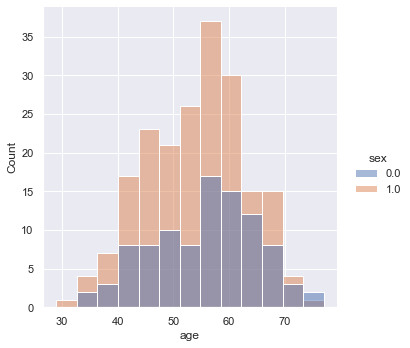

In [393]:
sns.displot(df, x="age", hue='sex')

In [394]:
num_m = len(df[df['sex'] == 1.0]) # number of males
num_f = len(df[df['sex'] == 0.0]) # number of females
print('Number of males in study are {} out of {}'.format(num_m,len(df)))
print('Number of females in study are {} out of {}'.format(num_f,len(df)))

Number of males in study are 201 out of 297
Number of females in study are 96 out of 297


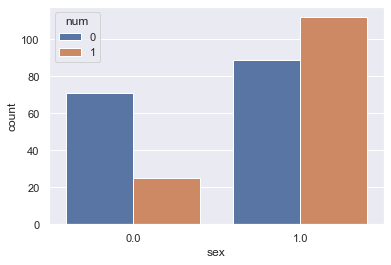

In [395]:
sns.countplot(x='sex', hue="num", data=df)

In [396]:
num_md = len(df[(df['num'] > 0) & (df['sex'] == 1.0)]) # males with heart disease
num_fd = len(df[(df['num'] > 0) & (df['sex'] == 0.0)]) # females with heart disease
print('Percentage of males in study with heart disease is {}%'.format(round(num_md/num_m*100,2)))
print('Percentage of females in study with heart disease is {}%'.format(round(num_fd/num_f*100,2)))

In [409]:
df.corr()[['num']].sort_values(by='num',ascending=False)

,num
num,1.000000
thal,0.526640
ca,0.463189
oldpeak,0.424052
exang,0.421355
cp,0.408945
slope,0.333049
sex,0.278467
age,0.227075
restecg,0.166343


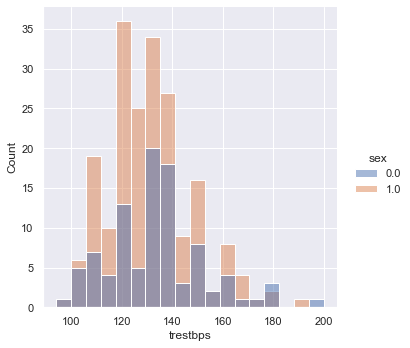

In [410]:
sns.displot(x="trestbps", hue='sex', data=df)

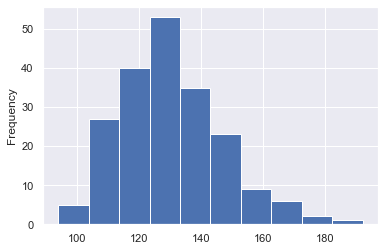

In [411]:
df[(df['trestbps'] > 0) & (df['sex'] == 1.0)].trestbps.plot(kind='hist')

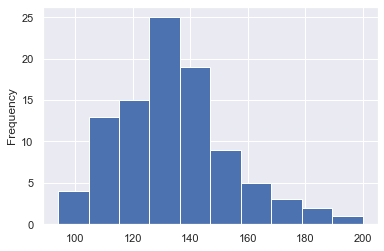

In [412]:
df[(df['trestbps'] > 0) & (df['sex'] == 0.0)].trestbps.plot(kind='hist')

# Statistics and Transformations

In [ ]:
stats = ols(formula='trestbps ~ age', data=df).fit()

In [ ]:
stats.summary()

In [ ]:
tmp = stats.params[1]*df['age'] + stats.params[0]

plt.scatter(df['age'], df['trestbps'])
plt.plot(df['age'], tmp, c='r')
plt.xlabel('age')
plt.ylabel('trestbps')
plt.title('trestbps vs. age');

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(20,16));

In [138]:
df['trestbps'].skew()
#df['trestbps'].kurtosis()

0.7000697177568133

In [132]:
df['thalach'].skew()

-0.5365400799355459

In [133]:
df['chol'].skew()

1.1180955225671279

In [134]:
df['oldpeak'].skew()

1.2471313241482946

In [120]:
pt = PowerTransformer()
pt_fit = pt.fit_transform(df['thalach'].values.reshape(-1,1))

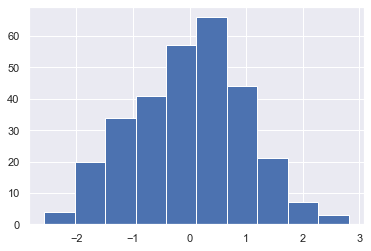

In [124]:
plt.hist(pt_fit);

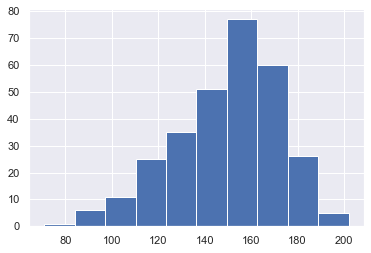

In [122]:
plt.hist(df['thalach']);

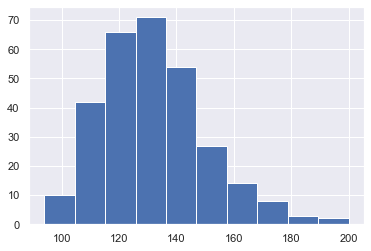

In [123]:
plt.hist(df['trestbps']);

In [135]:
sci_tmp = stats.boxcox_normmax(df['trestbps'].values)

/Users/DavidH/anaconda2/envs/py382/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [136]:
sci_tt = stats.boxcox(df['trestbps'].values, sci_tmp)

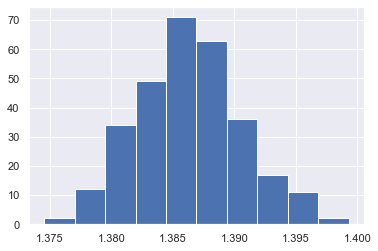

In [137]:
plt.hist(sci_tt);

In [146]:
stats.skew(sci_tt)

0.0037114288240650624

In [ ]:
plt.hist(df['oldpeak']);

In [145]:
stats.skew(box_thal)

-0.02153705136949472

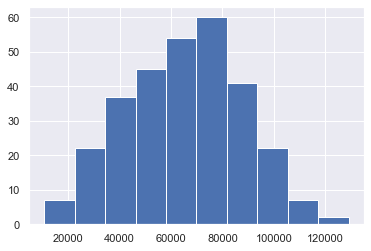

In [328]:
box_thal = stats.boxcox_normmax(df['thalach'].values)
box_thal = stats.boxcox(df['thalach'].values, box_thal)
df_T['thalach'] = box_thal
plt.hist(box_thal);

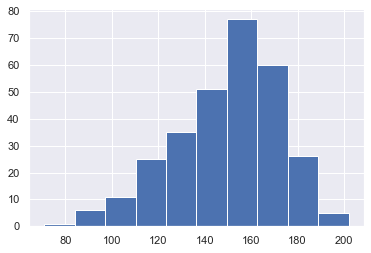

In [131]:
plt.hist(df['thalach']);

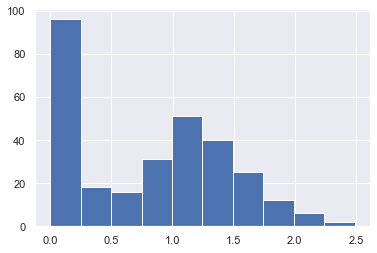

In [329]:
log_peak = np.sqrt(df['oldpeak'].values)
log_chol = np.sqrt(df['chol'].values)
log_bps = np.sqrt(df['trestbps'].values)
#box_peak = stats.yeojohnson(df['oldpeak'].values, box_peak)
df_T['oldpeak'] = log_peak
df_T['chol'] = log_chol
df_T['trestbps'] = log_bps
plt.hist(log_peak);

In [331]:
scaler = RobustScaler()
collist = df_T.columns.tolist()
collist.remove('num')
#df_T[['thalach','oldpeak','chol','trestbps']] = scaler.fit_transform(df_T[['thalach','oldpeak','chol','trestbps']])
df_T[collist] = scaler.fit_transform(df_T[collist])

## Dummy Variables

In [332]:
data = pd.get_dummies(df, prefix=['slope','thal','ca'], columns=['slope','thal','ca'])
data_T = pd.get_dummies(df_T, prefix=['slope','thal','ca'], columns=['slope','thal','ca'])

# Model without Transformations

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('num',axis=1), data['num'], test_size=0.2, random_state=42)

In [116]:
neigh = KNeighborsClassifier()
parameters = {
    'n_neighbors':[2,3,4,5,6,7,8,9],
    'weights':('uniform','distance'),
    'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
    'leaf_size':[15,20,25,30,35,40,45],
    'p':[1,2,3],
}
clf = GridSearchCV(neigh, parameters, cv=5, n_jobs=-1, verbose=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 3568 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed:   12.4s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': [15, 20, 25, 30, 35, 40, 45],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2, 3], 'weights': ('uniform', 'distance')},
             verbose=5)

In [191]:
clf.best_params_

{'algorithm': 'auto',
 'leaf_size': 15,
 'n_neighbors': 9,
 'p': 1,
 'weights': 'uniform'}

In [118]:
clf.best_score_

0.6918439716312056

In [119]:
clf.best_estimator_.score(X_test, y_test)

0.65

In [350]:
lr = LogisticRegression()
estimators = {
    'penalty':('l1', 'l2', 'elasticnet'),
    'tol':[1e-6,1e-5,1e-4,1e-3,1e-2],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'solver':('newton-cg','lbfgs','liblinear','sag','saga'),
    'max_iter':[10000]
}

clf_lr = GridSearchCV(lr, estimators, cv=5, n_jobs=-1, verbose=5)
clf_lr.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2081 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:   38.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'max_iter': [10000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'),
                         'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01]},
             verbose=5)

In [351]:
clf_lr.best_params_

{'C': 1.0,
 'max_iter': 10000,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.01}

In [352]:
clf_lr.best_score_

0.8311170212765957

In [353]:
clf_lr.best_estimator_.score(X_test, y_test)

0.8833333333333333

In [366]:
svc = SVC()
est_svc = {
    'kernel':('linear', 'sigmoid'),
    'degree':[3,4,5,6],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'tol':[1e-4,1e-3,1e-2],
    'gamma':('scale','auto')
}

clf_svc = GridSearchCV(svc, est_svc, cv=5, n_jobs=-1, verbose=5)
clf_svc.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1094 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   28.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   30.5s finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'degree': [3, 4, 5, 6], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'sigmoid'),
                         'tol': [0.0001, 0.001, 0.01]},
             verbose=5)

In [367]:
clf_svc.best_params_

{'C': 2.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}

In [368]:
clf_svc.best_score_

0.8355496453900709

In [369]:
clf_svc.best_estimator_.score(X_test,y_test)

0.85

In [374]:
rf = RandomForestClassifier()
est_rf = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[50,80,100,120,150,180,200],
    'max_depth':[None,1,2,3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2]
}

clf_rf = GridSearchCV(rf, est_rf, cv=5, n_jobs=-1, verbose=5)
clf_rf.fit(X_train, y_train)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 80, 100, 120, 150, 180, 200]},
             verbose=5)

In [375]:
clf_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [376]:
clf_rf.best_score_

0.835372340425532

In [377]:
clf_rf.best_estimator_.score(X_test,y_test)

0.8833333333333333

# Model with Transformations

In [333]:
X_tr, X_t, y_tr, y_t = train_test_split(data_T.drop('num',axis=1), data_T['num'], test_size=0.2, random_state=42)

In [334]:
neigh_T = KNeighborsClassifier()
parameters_T = {
    'n_neighbors':[2,3,4,5,6,7,8,9],
    'weights':('uniform','distance'),
    'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
    'leaf_size':[15,20,25,30,35,40,45],
    'p':[1,2,3],
}
clf_T = GridSearchCV(neigh_T, parameters_T, cv=5, n_jobs=-1, verbose=5)
clf_T.fit(X_tr, y_tr)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed:   13.2s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': [15, 20, 25, 30, 35, 40, 45],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2, 3], 'weights': ('uniform', 'distance')},
             verbose=5)

In [335]:
clf_T.best_params_

{'algorithm': 'auto',
 'leaf_size': 15,
 'n_neighbors': 7,
 'p': 1,
 'weights': 'distance'}

In [336]:
clf_T.best_score_

0.8312943262411349

In [337]:
clf_T.best_estimator_.score(X_t, y_t)

0.9

In [358]:
lr_T = LogisticRegression()
estimators_T = {
    'penalty':('l1', 'l2', 'elasticnet'),
    'tol':[1e-6,1e-5,1e-4,1e-3,1e-2],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'solver':('newton-cg','lbfgs','liblinear','sag','saga'),
    'max_iter':[10000]
}

clf_lr_T = GridSearchCV(lr_T, estimators_T, cv=5, n_jobs=-1, verbose=5)
clf_lr_T.fit(X_tr, y_tr)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1914 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:    2.6s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'max_iter': [10000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'),
                         'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01]},
             verbose=5)

In [359]:
clf_lr_T.best_params_

{'C': 0.01,
 'max_iter': 10000,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 1e-06}

In [360]:
clf_lr_T.best_score_

0.8310283687943263

In [361]:
clf_lr_T.best_estimator_.score(X_t, y_t)

0.9

In [366]:
svc = SVC()
est_svc = {
    'kernel':('linear', 'sigmoid'),
    'degree':[3,4,5,6],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'tol':[1e-4,1e-3,1e-2],
    'gamma':('scale','auto')
}

clf_svc = GridSearchCV(svc, est_svc, cv=5, n_jobs=-1, verbose=5)
clf_svc.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1094 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   28.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   30.5s finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'degree': [3, 4, 5, 6], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'sigmoid'),
                         'tol': [0.0001, 0.001, 0.01]},
             verbose=5)

In [367]:
clf_svc.best_params_

{'C': 2.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}

In [368]:
clf_svc.best_score_

0.8355496453900709

In [369]:
clf_svc.best_estimator_.score(X_test,y_test)

0.85

In [379]:
rf_T = RandomForestClassifier()
est_rf_T = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[50,80,100,120,150,180,200],
    'max_depth':[None,1,2,3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2]
}

clf_rf_T = GridSearchCV(rf_T, est_rf_T, cv=5, n_jobs=-1, verbose=5)
clf_rf_T.fit(X_tr, y_tr)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1176 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1986 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 80, 100, 120, 150, 180, 200]},
             verbose=5)

In [380]:
clf_rf_T.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [381]:
clf_rf_T.best_score_

0.8312943262411346

In [382]:
clf_rf_T.best_estimator_.score(X_t,y_t)

0.8833333333333333